<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple and Multiple Linear Regression from Scratch

_Authors: Kiefer Katovich (SF) and Matt Brems (DC)_

---

### Learning Objectives
- Code a simple linear regression from scratch using a simple housing price data set.
- Understand and code the loss function (mean squared error) MSE in regression.
- Write functions to calculate the R^2 metric.
- Understand what R^2 represents.
- Plot the regression line and predictions against the true values.
- Understand the difference between multiple linear regression (MLR) and simple linear regression.
- Derive the beta coefficients in MLR using linear algebra.
- Construct an MLR, calculate the coefficients manually, and evaluate the R^2.

### Lesson Guide
- [Load the Real Estate Data](#load-data)
- [Build a Simple Linear Regression (SLR)](#build-slr)
    - [Define the Target and Predictor Variables](#target-predictor)
    - [Code Prediction Function](#pred-func)
    - [Code Regression Plotting Function](#plot-regline)
    - [Code Function to Calculate Residuals](#calc-resids)
    - [Code Function to Calculate SSE](#calc-sse)
    - [Minimizing the SSE](#minimize-sse)    
- [R2: "The Coefficient of Determination"](#r2)
- [From SLR to Multiple Linear Regression (MLR)](#slr-to-mlr)
- [Assumptions of MLR](#assumptions)
- [Fitting an MLR](#fit-mlr)
    - [Deriving the MLR Coefficients with Linear Algebra](#mlr-beta-derivation)
    - [Code the MLR](#code-mlr)
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='load-data'></a>

## Load the Real Estate Data

---

Over the course of this lesson we will be constructing a simple linear regression (SLR) and then extending this to a multiple linear regression (MLR). Included in the `datasets` folder is a very simple data set on real estate prices.

**Load the data using Pandas.**

In [6]:
house_csv = './datasets/housing-data.csv'

df = pd.read_csv(house_csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
sqft     47 non-null int64
bdrms    47 non-null int64
age      47 non-null int64
price    47 non-null int64
dtypes: int64(4)
memory usage: 1.5 KB


The columns are:

    sqft: The size of the house in square feet.
    bdrms: Number of bedrooms.
    age: Age in years of house.
    price: The price of the house.
    
**Convert `price` to units of 1000 (thousands of dollars).**

In [12]:
df['price'] = df['price']/1000

<a id='build-slr'></a>

## Build an SLR: Estimating `price` with `sqft`

---

We will start by constructing the simple linear regression. Below is the formulation for the SLR and our specific model of interest:

### $$ y = \beta_0 + \beta_1 x + \epsilon \\
\text{price} = \beta_0 + \beta_1 \text{sqft} + \epsilon$$

> $\beta_0$: The intercept

Without the intercept term, the regression line would always have to pass through the origin, which is rarely an optimal way to represent the relationship between our target and predictor variables.

> $\beta_1$: The coefficient on $x$ 

We intend to estimate the values of $y$ from $x$. Each value of $x$ is multiplied by the same coefficient. This is why linear regression models model a _linear_ relationship between our predictor and target variables.

Recall that a 1-unit increase in $x$ will correspond to a $\beta_1$ unit increase in $y$ according to our model.

> $\epsilon_1$: The error (residuals)

This is the difference between the predicted and true values that are unexplained by $x$ in the regression.

---

<a id='target-predictor'></a>

### Define the Target and Predictor Variables

Extract the target variable and predictor variable from our Pandas DataFrame. Classically, target and predictor are referred to as dependent and independent variables, respectively. There are many different terms for what $x$ and $y$ represent.

In [30]:
y = df['price'].reshape(-1,1)
x = df['sqft'].reshape(-1,1)

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


<a id='pred-func'></a>

### Build a Function to Predict $\hat{y}$ Given $x$

Build a function to represent the formula below:

### $$\hat{y} = \beta_0 + \beta_1 x$$

**Note:** We have removed the error term from the equation. Obviously, we do not know the error or we would be able to model $y$ perfectly. We assume that our prediction $\hat{y}$ is an imperfect estimation of $y$.

In [38]:
import sklearn.linear_model as lm
import scipy.stats

In [51]:
def regression(x_array, y_array, x_topredict):
    corr = scipy.stats.pearsonr(x_array, y_array)[0]
    y_std = y_array.std()
    x_std = x_array.std()
    beta1 = corr*(y_std/x_std)
    beta0 = y_array.mean() - beta1*x_array.mean()
    predicted_y = beta0 + beta1*x_topredict
    return beta0, beta1, predicted_y

In [45]:
def regression2(x_array, y_array, x_topredict):
    lr = lm.LinearRegression().fit(x_array, y_array)
    print lr.predict(x_topredict)

In [77]:
regression(x, y, 1600)

(array([71.27049245]), array([0.13452529]), array([286.5109528]))

In [78]:
regression2(x, y, 1600)

[[286.5109528]]


<a id='plot-regline'></a>

### Write a Function to Plot a Regression Line

Your function should:
- Accept $\beta_0$, $\beta_1$, $x$, and $y$ as arguments.
- Calculate the predicted values $\hat{y}$ given $x$ (using the function you wrote above).
- Plot the original points.
- Plot the predicted points (in a different color).
- Plot the regression line defined by the slope and intercept.

In [152]:
def regplot(x_array, y_array, x_topredict):
    #run the regression
    beta0, beta1, predicted_y = regression(x_array, y_array, x_topredict)

    # create a figure
    fig = plt.figure(figsize=(15,7))
    # get the axis
    ax = fig.gca()

    # plot datapoints
    ax.scatter(x_array, y_array, c='k')
    # get y_hat line and plot
    y_hat = beta0 + beta1*x_array
    ax.plot(x_array, y_hat, color='k')
    #plot predicted points given x to predict
    ax.scatter(x_topredict, predicted_y, color='red', marker="^", s=500);

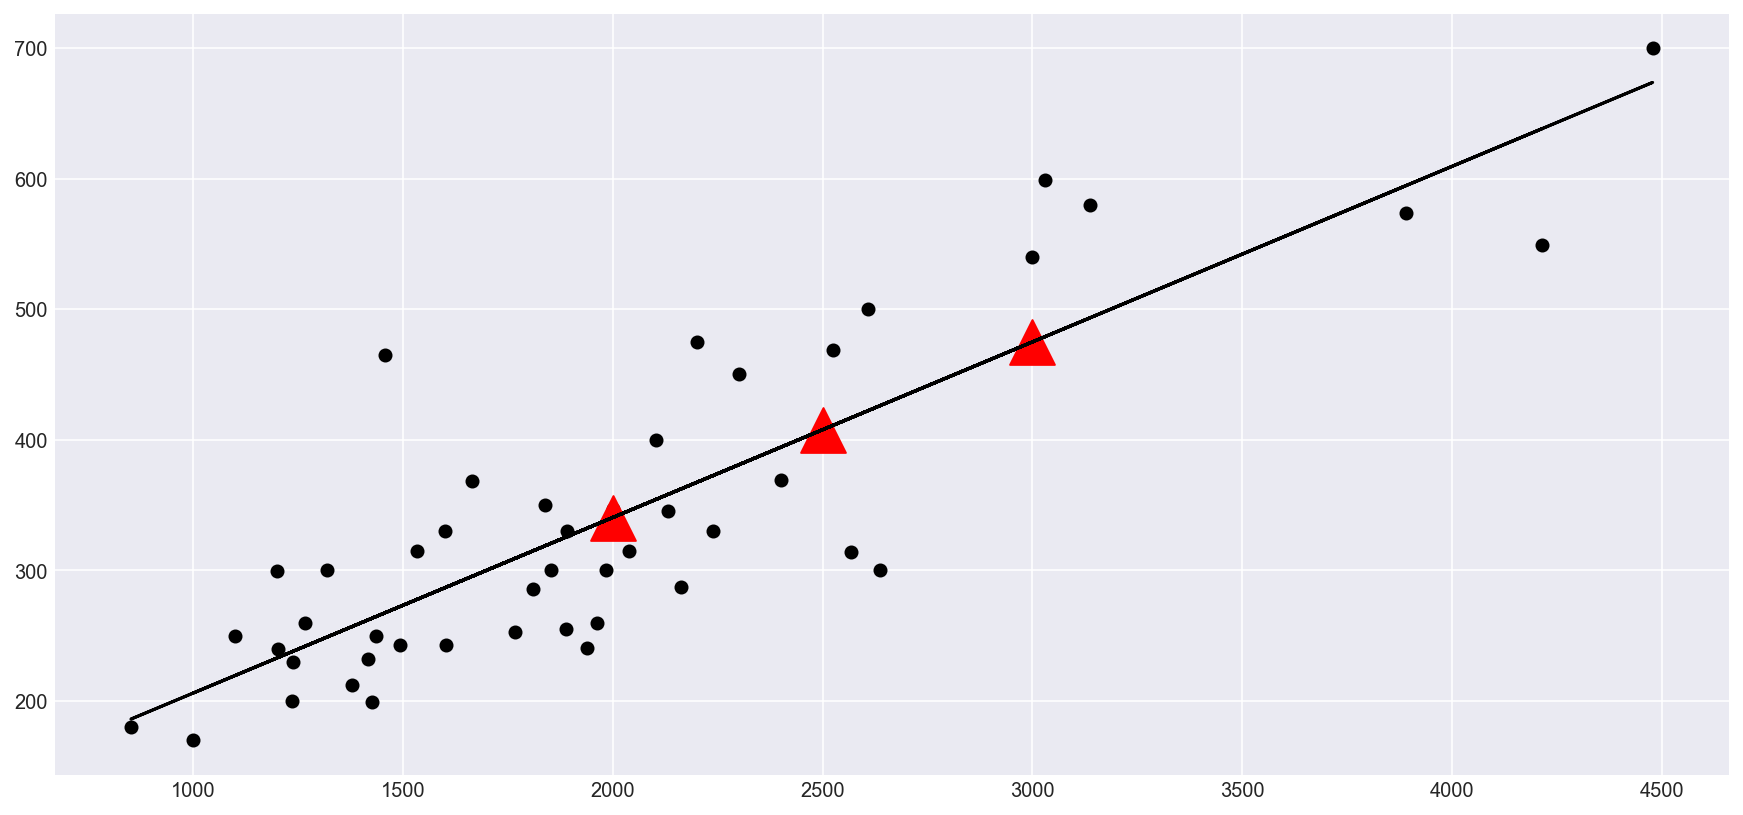

In [153]:
regplot(x, y, [2000,2500,3000])

**Use your function with $\beta_0 = 0$ and $\beta_1 = 1$.**

In [102]:
def regplot2(beta_0, beta_1, x_array, y_array, x_topredict):
    #run the regression
    beta0, beta1, predicted_y = regression(x_array, y_array, x_topredict)

    # create a figure
    fig = plt.figure(figsize=(15,7))
    # get the axis
    ax = fig.gca()

    # plot datapoints
    ax.scatter(x_array, y_array, c='k')
    # get y_hat line and plot
    y_hat = beta_0 + beta_1*x_array
    ax.plot(x_array, y_hat, color='k')
    #plot predicted points given x to predict
    ax.scatter(x_topredict, predicted_y, color='red', marker="^", s=500);

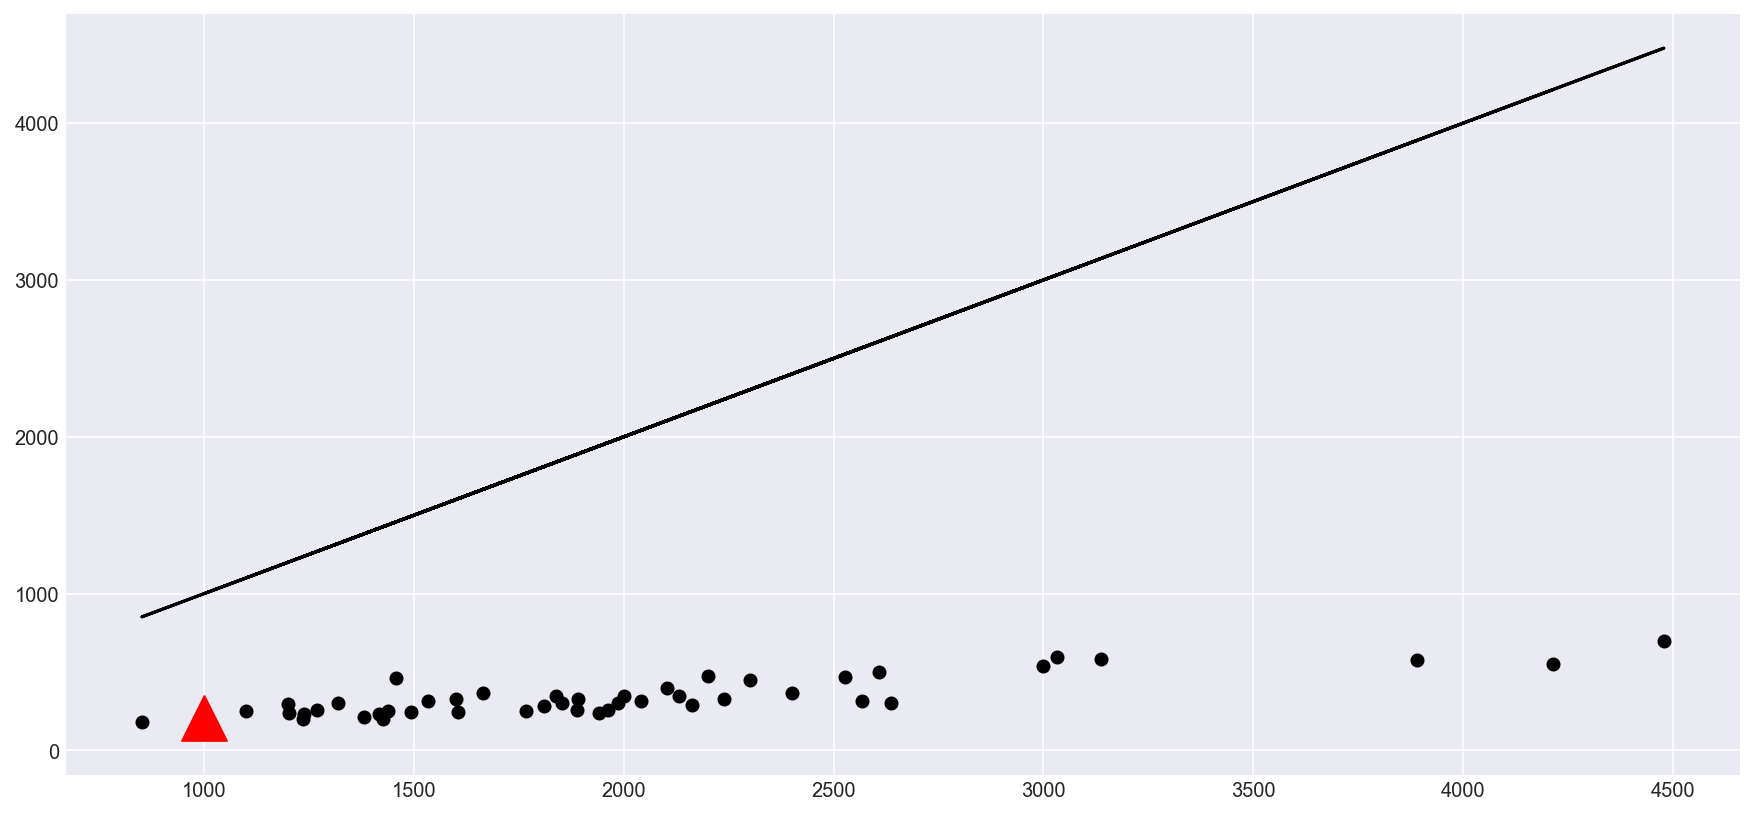

In [103]:
regplot2(0, 1, x, y, 1000)

<a id='calc-resids'></a>

### Write a Function to Calculate Residuals

Recall that the residuals are simply the error of the model:

### $$ \text{residual}_i = y_i - \hat{y}_i$$

Where $y_i$ is the true value of our target at this observation $i$, $\hat{y}_i$ is the predicted value of our target.

In [119]:
def res(x_array, y_array):
    lr = lm.LinearRegression().fit(x_array, y_array)
    y_hat = lr.predict(x_array)
    return y - y_hat

In [121]:
res(x, y)

array([[  45.58830219],
       [  43.3890472 ],
       [ -25.13118298],
       [ -29.75829986],
       [  65.05364439],
       [ -38.40318857],
       [  37.26771619],
       [ -64.23907803],
       [ -44.9153895 ],
       [ -29.7512723 ],
       [ -92.25055063],
       [   6.67893211],
       [   4.47571376],
       [  26.22526914],
       [  18.05144272],
       [  69.22134579],
       [  51.05612776],
       [ -37.64374807],
       [  77.75103189],
       [ 119.98336047],
       [ -56.07667585],
       [ -70.25423566],
       [ -44.14905395],
       [ -75.30910696],
       [ -20.67386168],
       [  30.65169106],
       [ 197.09163806],
       [  57.91863077],
       [ 107.77387457],
       [-126.11367617],
       [  31.23750343],
       [ -35.89578017],
       [ -30.8020794 ],
       [  86.62367997],
       [ -28.99578851],
       [ -14.6833309 ],
       [  -8.04732393],
       [ -13.07840587],
       [ -89.29458019],
       [ -75.1141645 ],
       [  73.37942878],
       [ -42.438

<a id='calc-sse'></a>

### Write a Function to Calculate the Sum of Squared Errors (SSE)

Simple linear regression can use the "ordinary least squares" method for identifying linear relations between variables. Here the term ["least squares"](https://www.mathworks.com/help/optim/ug/least-squares-model-fitting-algorithms.html) means that it _minimizes the sum of the squared residuals._


> **Aside:** Why use the squared residuals instead of just the absolute value of the residuals? Well, both can be used, but absolute value of residuals is typically used when there are large outliers or other abnormalities in variables. [Solving for the least absolute deviations (LAD)](https://en.wikipedia.org/wiki/Least_absolute_deviations) is a type of "robust" regression.


In [148]:
def SSE(x_array, y_array):
    lr = lm.LinearRegression().fit(x_array, y_array)
    y_hat = lr.predict(x_array)
    return ((y - y_hat)**2).sum()

In [149]:
SSE(x, y)

193464.4776007059

**Calculate the sum of squared errors from your initial regression with $\beta_0 = 0$ and $\beta_1 = 1$ using the functions we defined earlier.**


In [166]:
def SSE2(beta_0, beta_1, x_array):
    y_hat = beta_0 + beta_1*x_array
    return ((y - y_hat)**2).sum()

In [168]:
SSE2(0, 1, df['sqft'].reshape(-1,1))

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


151509353.472007

**Choose a new $\beta_0$ and $\beta_1$ you think might be better, and calculate the SSE.**

In [150]:
SSE(x, y)

193464.4776007059

In [ ]:
def 

<a id='minimize-sse'></a>

### Minimizing the Sum of Squared Errors

In simple linear regression, we can use calculus to derive the equation that minimizes the sum of squared errors. [See here](http://web.cocc.edu/srule/MTH244/other/LRJ.PDF) or [here](https://en.wikipedia.org/wiki/Simple_linear_regression) for descriptions of the derivation.

For those familiar with calculus, **set the derivative of the loss function to 0 and solve for $\beta_0$ and $\beta_1$.** The loss function is "convex" and therefore it is at its minimum where the derivative is 0. Solving involves taking the partial derivatives for $\beta_0$ and $\beta_1$. 

The equations for the $\beta_0$ and $\beta_1$ that minimize the sum of squares are:

### $$ \beta_1 = \frac{\sum_{i=1}^n (y_i - \bar{y} ) (x_i - \bar{x} )}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

and

### $$ \beta_0 = \bar{y} - \beta_1\bar{x} $$

where $\bar{x}$ and $\bar{y}$ are the sample means of $x$ and $y$, respectively.

#### Write Functions Below to Calculate $\beta_0$ and $\beta_1$ Based on These Equations

In [162]:
def betas(x, y):
    beta_1 = (((y - y.mean())*(x - x.mean())).sum())/((x - x.mean())**2).sum()
    beta_0 = y.mean() - beta_1*x.mean()
    return beta_0, beta_1

**Calculate the optimal $\beta_1$ and $\beta_0$ using your functions.**

In [163]:
betas(x, y)

(71.27049244872916, 0.1345252877202413)

**Plot the regression with the optimal betas and calculate the SSE.**

(71.27049244872916, 0.1345252877202413)

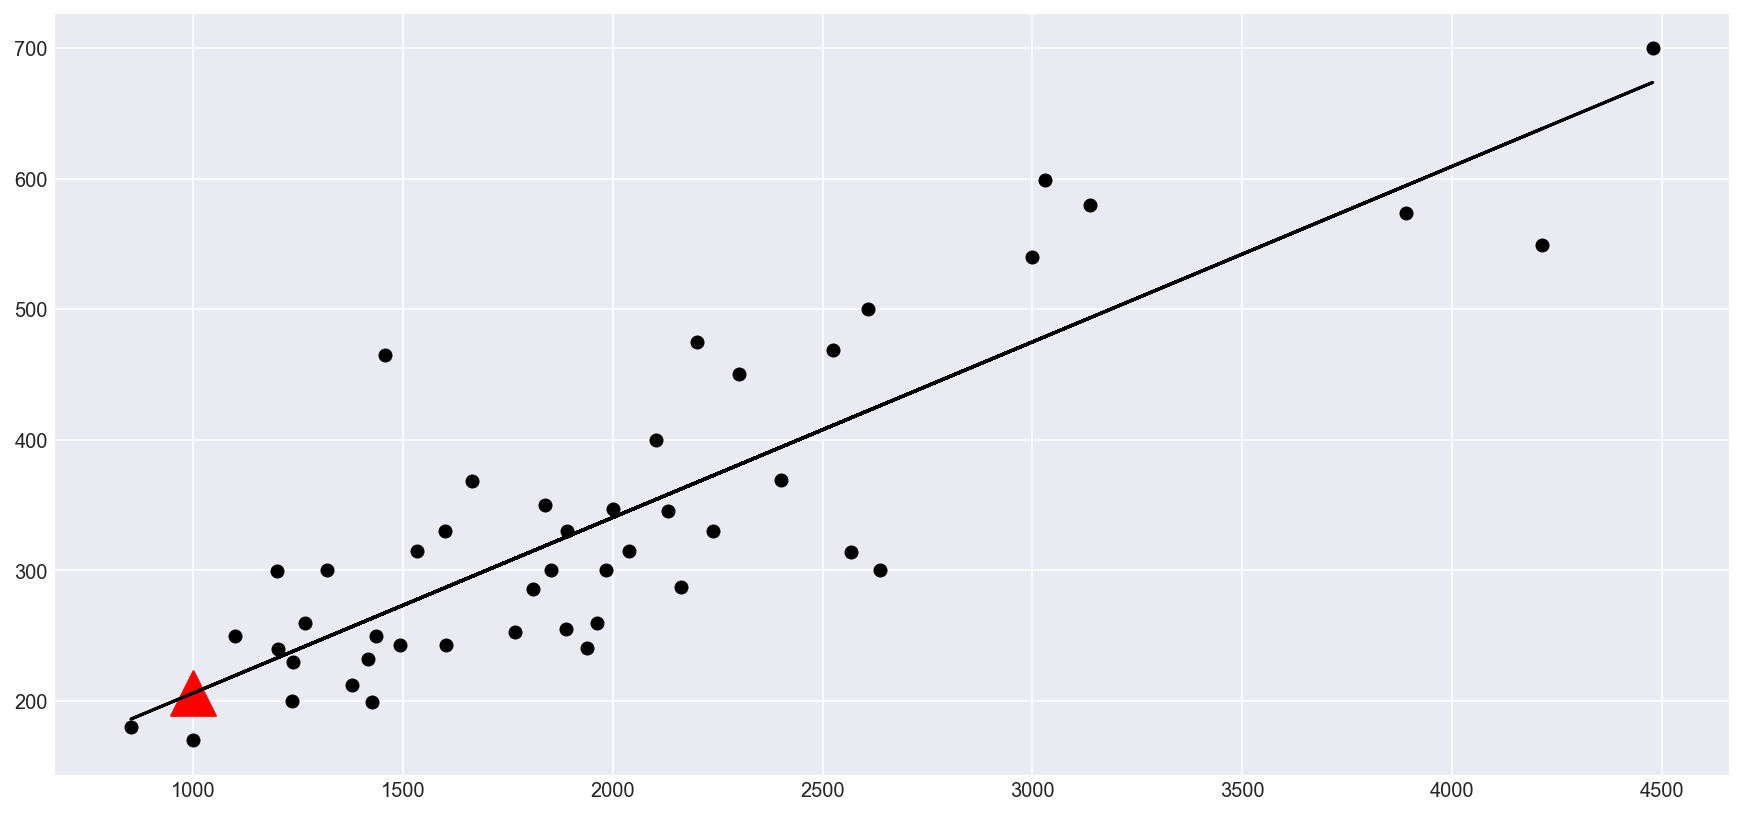

In [165]:
regplot(x, y, 1000)
betas(x, y)

<a id='r2'></a>

## $R^2$: The "Coefficient of Determination"

---

> **$R^2$ is the amount of variance explained above baseline in your target $y$ by predictor $x$**.

It is composed of two parts: the **total sum of squares** and the **residual sum of squares**.

The total sum of squares is defined as:

### $$ SS_{tot} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2 $$

You are already familiar with the residual sum of squares. It is defined as:

### $$ SS_{res} = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$

$R^2$ is then calculated with:

### $$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

The total sum of squares is the **baseline model**: the amount of variance in $y$ we would explain if we were to predict each point of $y$ using just the mean of $y$, $\bar{y}$.

This is equivalent to estimating $y$ by fitting a regression with nothing but the intercept term $\beta_0$, which becomes the mean of $y$ (the best possible estimator of $y$ using a single value):

### $$ \hat{y} = \beta_0 = \bar{y} $$


As the quotient of the the $SS_{res}$ and $SS_{tot}$ decreases, the $R^2$ value gets closer to 1. While the maximum $R^2$ is 1, an $R^2$ can be infinitely negative as well. Having a negative $R^2$ indicates that your predictive equation has greater error than the baseline mode.  

_In other words, your equation is worse at representing the relationship than a horizontal line through the Y intercept._

#### Plot your regression again, with a new regression line representing the baseline model.

In [186]:
baseline = [y.mean()]*len(y)

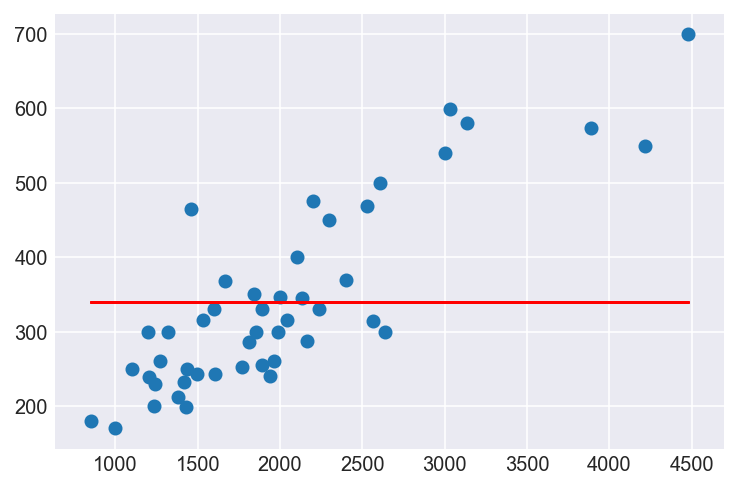

In [187]:
plt.plot(x, baseline, c='r')
plt.scatter(x, y)

**Calculate the SSE for the baseline model and for the model with predictor `sqft`.**

In [188]:
SSE(x, baseline)

33802819.168304

In [189]:
SSE(x, y)

193464.4776007059

#### Write a function to calculate $R^2$. Print out the $R^2$ of your model.

In [235]:
def R_2(x, y):
    err_total = ((y - y.mean())**2).sum()
    R_2 = 1 - (SSE(x, y) / err_total) 
    return R_2

In [236]:
R_2(x, y)

0.7310037839755306

<a id='slr-to-mlr'></a>

## From Simple Linear Regression (SLR) to Multiple Linear Regression (MLR)

---

The TL;DR of multiple linear regression:

> Instead of using just one predictor to estimate a continuous target, we build a model with multiple predictor variables. You will be using MLR much more frequently than SLR going forward.

These variables will be represented as columns in a matrix (often a Pandas DataFrame).

**Brainstorm some examples of real-world scenarios where multiple predictors would be beneficial. Can you think of cases where it might be detrimental?**

In [ ]:
# A:

<a id='assumptions'></a>

## Assumptions of MLR

---

Like SLR, there are assumptions associated with MLR. Luckily, they're quite similar to the SLR assumptions:

1) **Linearity:** $Y$ must have an approximately linear relationship with each independent $X_i$.

2) **Independence:** Errors (residuals) $\epsilon_i$ and $\epsilon_j$ must be independent of one another for any $i \ne j$.

3) **Normality:** The errors (residuals) follow a normal distribution.

4) **Equality of Variances**: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the $X_i$ predictors. (There should be no discernable relationship between the $X$ predictors and the residuals.)

5) **Independence of Predictors**: The independent variables $X_i$ and $X_j$ must be independent of one another for any $i \ne j$.

The mnemonic LINEI is a useful way to remember these five assumptions. 

<a id='fit-mlr'></a>

## Fitting a Multiple Linear Regression

---

The formula for computing the $\beta$ values in multiple regression is best done using linear algebra. We will cover the derivation, but for more details  [these slides are a great resource](http://statweb.stanford.edu/~nzhang/191_web/lecture4_handout.pdf).

$X$ is now a _matrix_ of predictors $x_1$ through $x_i$ (with each column a predictor), and $y$ is the target vector we are seeking to estimate. There is still only one *estimated* variable!

### $$ \hat{y} = \beta X$$

**Note:** $\beta$ in the formula above is a *vector* of coefficients now, rather than a single value.

In different notation we could write $\hat{y}$ calculated with:

### $$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

---

<a id='mlr-beta-derivation'></a>

### Deriving the $\beta$ coefficients with linear algebra

$\beta$ is solved with the linear algebra formula:

### $$ \beta = (X'X)^{-1}X'y $$

Where $X'$ is the transposed matrix of original matrix $X$ and $(X'X)^-1$ is the inverted matrix of $X'X$.



The equation using true $y$ is:

### $$ y = \beta X + \epsilon $$

Again, $\epsilon$ is our vector of errors, or residuals.

We can equivalently formulate this in terms of the residuals as:

### $$ \epsilon = \beta X - y $$

Our goal is to minimize the sum of squared residuals. The sum of squared residuals is equivalent to the dot product of the vector of residuals:

### $$ \sum_{i=1}^n \epsilon_i^2 = 
\left[\begin{array}{cc}
\epsilon_1 \cdots \epsilon_n
\end{array}\right] 
\left[\begin{array}{cc}
\epsilon_1 \\ \cdots \\ \epsilon_n
\end{array}\right] = \epsilon' \epsilon
$$

Therefore we can write the sum of squared residuals as:

### $$ \epsilon' \epsilon = (\beta X - y)' (\beta X - y) $$

Which becomes:

### $$ \epsilon' \epsilon = y'y - y'X\beta - \beta' X' y + \beta' X' X \beta $$

Now take the derivative with respect to $\beta$:

### $$ \frac{\partial \epsilon' \epsilon}{\partial \beta} = 
-2X'y + 2X'X\beta$$

We want to minimize the sum of squared errors, and so we set the derivative to 0 and solve for the beta coefficient vector:

### $$ 0 = -2X'y + 2X'X\beta \\
X'X\beta = X'y \\
\beta = (X'X)^{-1}X'y$$

<a id='code-mlr'></a>

### Code an MLR

**First, we need to create the "design matrix" of our predictors.**

The first column will be a column of all 1s (the intercept) and the other columns will be `sqft`, `bdrms`, and `age`.

This is easiest to do with Pandas. Add a column for the intercept first, then extract the matrix using `.values`.

In [259]:
X = df[['sqft','bdrms','age']]
X['intercept'] = 1
X = X[['intercept','sqft','bdrms','age']]
X = X.values
print X[0:3, :]

[[   1 2104    3   70]
 [   1 1600    3   28]
 [   1 2400    3   44]]


### Solve for the Beta Coefficients

We are still predicting `price`. Implement the linear algebra equation to solve for the beta coefficients. 

### $$ \beta = (X'X)^{-1}X'y $$

**Tips:**

The transpose of a matrix is calculated by appending `.T` to the matrix:

    X.T

Matrices multiplied in the formula should be done with the "dot product:"

    np.dot(mat1, mat2)

Inverting a matrix is done using:

    np.linalg.inv()

In [247]:
beta_vec = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)),X.T), y.reshape(-1,1))
print beta_vec

[[ 9.24516278e+01]
 [ 1.39334847e-01]
 [-8.62147046e+00]
 [-8.12178776e-02]]


**Confirm that these betas are the same as the ones using `sklearn.linear_model.LinearRegression`**

```python
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, price)

print linreg.coef_
```

In [245]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, y)

print linreg.coef_

[[ 9.24516278e+01  1.39334847e-01 -8.62147046e+00 -8.12178776e-02]]


**Calculate predicted $\hat{y}$ with your $X$ predictor matrix and $\beta$ coefficients.**

In [261]:
print X.shape
print beta_vec.shape

(47L, 4L)
(4L, 1L)


In [265]:
y_hat = np.dot(X, beta_vec)

**Calculate the $R^2$ of the multiple regression model.**

In [268]:
def R_2(y, y_hat):
    err_total = ((y - y.mean())**2).sum()
    err_res = ((y - y_hat)**2).sum()
    R_2 = 1 - (err_res / err_total) 
    return R_2

In [269]:
R_2(y, y_hat)

0.7331639990690024

<a id='additional-resources'></a>

## Additional Resources

---

[Maximum-Likelihood Estimation](https://onlinecourses.science.psu.edu/stat504/node/28)